In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !apt-get -qq install --no-install-recommends nvidia-375
# !apt-get -qq install --no-install-recommends nvidia-opencl-icd-375 nvidia-opencl-dev opencl-headers
# !apt-get -qq install --no-install-recommends git cmake build-essential libboost-dev libboost-system-dev libboost-filesystem-dev
# !pip3 install -qq lightgbm --install-option=--gpu

!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM

rm: cannot remove '/opt/conda/lib/python3.6/site-packages/lightgbm': No such file or directory
Cloning into 'LightGBM'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 13507 (delta 0), reused 0 (delta 0), pack-reused 13502
Receiving objects: 100% (13507/13507), 9.56 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (9648/9648), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 72, done.        
remote: Counting objects: 100% (72/72), done.        
remote: Compressing objects: 100% (47/47), done.        
remote: Total 21728 (delta 30), reused 44 (delta 19), pack-reused 21656        
Receiving objects: 100% (21728/21728), 8.53 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (17550/17550), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6

In [0]:
!apt-get install -y -qq libboost-all-dev

In [4]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking

rm: cannot remove 'build': No such file or directory


In [5]:
!cd LightGBM/python-package/;python3 setup.py install --precompile

running install
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading man

In [0]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

In [0]:
# !git clone --recursive https://github.com/Microsoft/LightGBM
# %cd LightGBM
# !mkdir build
# !cd build
# !cmake ./LightGBM
# !make -j4

# !git clone --recursive https://github.com/Microsoft/LightGBM.git
# %cd LightGBM/python-package
# !python3 setup.py install --gpu

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in

In [0]:
labels_df = pd.read_csv(f'{PATH_LABELS}/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

In [11]:
sub_df = pd.read_pickle(f'{PATH_FEATURES}/sub_df_100.pkl')

sub_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891,0
1,0,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516,0
2,0,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825,0
3,0,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.728397,0
4,0,8.0,38.000866,-0.889590,-8.826669,-1.920493,0.041287,-0.017650,0.033933,1037.0,12.354941,0


In [6]:
len(sub_df)

1998200

## EDA

In [7]:
sub_df.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06
mean,8.161654e+11,1.061140e+01,1.684718e+02,7.244688e-02,4.579389e+00,9.075932e-01,-2.046001e-03,2.152561e-05,-2.651337e-04,4.199983e+03,8.423657e+00,2.493744e-01
std,4.944606e+11,7.623948e+01,1.078981e+02,1.407409e+00,8.070876e+00,3.221037e+00,1.423460e-01,3.193392e-01,1.516832e-01,1.517685e+06,7.825821e+00,4.326510e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-2.687987e+01,-5.203878e+01,-5.711064e+01,-2.927131e+01,-5.887993e+01,-2.818092e+01,0.000000e+00,-1.000000e+00,0.000000e+00
25%,3.865471e+11,3.900000e+00,7.655327e+01,-5.049608e-01,-6.440599e-01,-9.171051e-01,-2.670214e-02,-3.027998e-02,-1.878666e-02,1.660000e+02,8.132748e-01,0.000000e+00
50%,7.988639e+11,4.288000e+00,1.690000e+02,6.026306e-02,9.107821e+00,7.709565e-01,-6.933320e-04,2.288818e-04,-7.629395e-05,3.940000e+02,6.730000e+00,0.000000e+00
75%,1.245541e+12,8.000000e+00,2.630000e+02,6.343323e-01,9.713572e+00,2.743839e+00,2.282715e-02,3.158569e-02,1.810950e-02,6.940000e+02,1.435960e+01,0.000000e+00
max,1.709397e+12,6.063000e+03,3.599967e+02,5.134041e+01,5.838979e+01,7.288908e+01,1.830983e+01,5.550382e+01,4.505986e+01,6.193158e+08,8.803725e+01,1.000000e+00


## Feature engineering

In [0]:
sub_df.columns.tolist()

['bookingID',
 'Accuracy',
 'Bearing',
 'acceleration_x',
 'acceleration_y',
 'acceleration_z',
 'gyro_x',
 'gyro_y',
 'gyro_z',
 'second',
 'Speed',
 'label']

In [0]:
def total_acc(df):
    # acceleration combining all directions
    total_acc = np.power(df['acceleration_x'].values, 2) + \
                np.power(df['acceleration_y'].values, 2) + \
                np.power(df['acceleration_z'].values, 2)
    
    df['total_acc'] = np.sqrt(total_acc)
    
def total_gyro(df):
    # gyro combining all directions
    total_gyro = np.power(df['gyro_x'].values, 2) + \
                 np.power(df['gyro_y'].values, 2) + \
                 np.power(df['gyro_z'].values, 2)
    
    df['total_gyro'] = np.sqrt(total_gyro)
    
total_acc(sub_df)
total_gyro(sub_df)

In [0]:
accs = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'total_acc']
gyros = ['gyro_x', 'gyro_y', 'gyro_z', 'total_gyro']
speed = ['Speed']

features = accs + gyros + speed

def group_features(in_, features):
    # features grouped by bookingID
    out_ = pd.DataFrame()
    
    out_['bookingID'] = in_['bookingID'].unique()
    
    def first_order(x):
        # first order diff
        return np.mean(np.diff(x))

    def second_order(x):
        # second order diff
        return np.mean(np.diff(np.diff(x)))   
    
    # statistical features
    for feature in features:
            
        out_[feature + '_mean'] = in_.groupby('bookingID')[feature].mean().values        
        out_[feature + '_min'] = in_.groupby('bookingID')[feature].min().values
        out_[feature + '_max'] = in_.groupby('bookingID')[feature].max().values
        out_[feature + '_std'] = in_.groupby('bookingID')[feature].std().values
        
        out_[feature + '_fo_mean'] = in_.groupby('bookingID')[feature]\
                                            .apply(first_order).values  
        out_[feature + '_so_mean'] = in_.groupby('bookingID')[feature]\
                                            .apply(second_order).values                
    return out_

In [0]:
new = group_features(sub_df, features)

In [0]:
new.head()

,bookingID,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_z_mean,acceleration_z_min,acceleration_z_max,acceleration_z_std,acceleration_z_fo_mean,acceleration_z_so_mean,total_acc_mean,total_acc_min,total_acc_max,total_acc_std,total_acc_fo_mean,total_acc_so_mean,gyro_x_mean,gyro_x_min,gyro_x_max,gyro_x_std,gyro_x_fo_mean,gyro_x_so_mean,gyro_y_mean,gyro_y_min,gyro_y_max,gyro_y_std,gyro_y_fo_mean,gyro_y_so_mean,gyro_z_mean,gyro_z_min,gyro_z_max,gyro_z_std,gyro_z_fo_mean,gyro_z_so_mean,total_gyro_mean,total_gyro_min,total_gyro_max,total_gyro_std,total_gyro_fo_mean,total_gyro_so_mean,Speed_mean,Speed_min,Speed_max,Speed_std,Speed_fo_mean,Speed_so_mean
0,0,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.213740,0.002936,0.006258,9.901510,8.357991,12.988328,0.662304,0.001975,0.005938,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,0.106781,0.000545,0.000167,-0.007324,-0.284009,0.209767,0.059477,-0.000295,0.000185,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,7.844813,0.064309,21.240761,6.861628,2.134613e-03,-1.985995e-01
1,1,-0.515797,-2.370662,3.387767,0.675866,0.005570,0.005714,9.547557,7.771339,10.728791,0.502611,0.000484,0.011288,-2.176563,-4.806848,-0.062996,0.865198,-0.002507,0.018813,9.870474,8.455773,10.871560,0.422207,0.000737,0.005228,-0.001604,-0.054210,0.061959,0.021566,0.000323,0.000089,-0.019800,-0.573742,0.210347,0.085879,-0.000085,-0.000627,-0.001443,-0.062675,0.136467,0.026840,0.000283,-0.000057,0.056473,0.003648,0.589819,0.075762,0.000401,-0.001011,7.213234,-1.000000,21.858812,6.792266,1.036210e-01,-2.316663e-01
2,2,0.365558,-1.728666,1.834015,0.699327,-0.013205,0.004715,9.835035,8.248277,11.559559,0.440514,-0.002733,-0.000464,0.180456,-3.282551,2.312870,1.021426,-0.003845,0.013999,9.919853,8.334944,11.718406,0.449217,-0.003073,-0.000383,0.008800,-0.155218,0.241234,0.057002,0.000031,-0.000480,-0.023570,-0.462000,0.297305,0.116870,0.003005,-0.002980,0.002607,-0.084979,0.255884,0.039991,-0.000315,0.000131,0.100827,0.005845,0.463685,0.094258,-0.002705,0.002360,3.126265,0.000000,9.360483,2.848020,2.691450e-17,4.531523e-18
3,4,-0.297979,-2.650528,1.785162,0.598809,-0.020397,0.018062,-9.445157,-15.253134,-8.106802,0.719555,0.003562,-0.003339,-2.579531,-5.193839,-0.906488,0.774801,-0.034721,-0.012042,9.842355,8.554923,16.157423,0.741068,0.004631,0.010151,-0.024235,-0.113330,0.094424,0.029816,0.000165,-0.001267,0.022005,-0.343034,0.477722,0.119418,-0.002787,0.001673,0.011805,-0.108571,0.234811,0.054717,-0.000210,0.001258,0.106024,0.022119,0.481976,0.089510,-0.002550,0.001770,6.079600,0.000000,18.480000,5.383002,9.696969e-03,-1.014286e-01
4,6,0.424960,-3.047912,2.250618,0.760655,-0.005901,-0.001099,9.644498,8.166871,12.823736,0.655483,0.005442,0.005277,2.417116,-1.438959,6.038361,1.063747,0.001475,-0.004153,10.034272,8.603480,14.498268,0.689889,0.005427,0.003892,0.004045,-0.200405,0.243694,0.054953,0.000154,-0.000150,0.002277,-0.513678,0.380017,0.108827,0.000012,0.005124,-0.006090,-0.135764,0.222203,0.047414,-0.000056,0.001297,0.086772,0.005723,0.518669,0.097802,-0.000157,-0.004697,3.884060,0.000000,15.783421,5.010923,-2.467162e-17,-1.206307e-02


In [107]:
new_labels = pd.merge(new, labels_df,
                      left_on='bookingID', right_on='bookingID',
                      how='inner')

new_labels.head()

,bookingID,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_z_mean,acceleration_z_min,acceleration_z_max,acceleration_z_std,acceleration_z_fo_mean,acceleration_z_so_mean,total_acc_mean,total_acc_min,total_acc_max,total_acc_std,total_acc_fo_mean,total_acc_so_mean,gyro_x_mean,gyro_x_min,gyro_x_max,gyro_x_std,gyro_x_fo_mean,gyro_x_so_mean,gyro_y_mean,gyro_y_min,gyro_y_max,gyro_y_std,gyro_y_fo_mean,gyro_y_so_mean,gyro_z_mean,gyro_z_min,gyro_z_max,gyro_z_std,gyro_z_fo_mean,gyro_z_so_mean,total_gyro_mean,total_gyro_min,total_gyro_max,total_gyro_std,total_gyro_fo_mean,total_gyro_so_mean,Speed_mean,Speed_min,Speed_max,Speed_std,Speed_fo_mean,Speed_so_mean,label
0,0,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.213740,0.002936,0.006258,9.901510,8.357991,12.988328,0.662304,0.001975,0.005938,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,0.106781,0.000545,0.000167,-0.007324,-0.284009,0.209767,0.059477,-0.000295,0.000185,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,7.844813,0.064309,21.240761,6.861628,2.134613e-03,-1.985995e-01,0
1,1,-0.515797,-2.370662,3.387767,0.675866,0.005570,0.005714,9.547557,7.771339,10.728791,0.502611,0.000484,0.011288,-2.176563,-4.806848,-0.062996,0.865198,-0.002507,0.018813,9.870474,8.455773,10.871560,0.422207,0.000737,0.005228,-0.001604,-0.054210,0.061959,0.021566,0.000323,0.000089,-0.019800,-0.573742,0.210347,0.085879,-0.000085,-0.000627,-0.001443,-0.062675,0.136467,0.026840,0.000283,-0.000057,0.056473,0.003648,0.589819,0.075762,0.000401,-0.001011,7.213234,-1.000000,21.858812,6.792266,1.036210e-01,-2.316663e-01,1
2,2,0.365558,-1.728666,1.834015,0.699327,-0.013205,0.004715,9.835035,8.248277,11.559559,0.440514,-0.002733,-0.000464,0.180456,-3.282551,2.312870,1.021426,-0.003845,0.013999,9.919853,8.334944,11.718406,0.449217,-0.003073,-0.000383,0.008800,-0.155218,0.241234,0.057002,0.000031,-0.000480,-0.023570,-0.462000,0.297305,0.116870,0.003005,-0.002980,0.002607,-0.084979,0.255884,0.039991,-0.000315,0.000131,0.100827,0.005845,0.463685,0.094258,-0.002705,0.002360,3.126265,0.000000,9.360483,2.848020,2.691450e-17,4.531523e-18,1
3,4,-0.297979,-2.650528,1.785162,0.598809,-0.020397,0.018062,-9.445157,-15.253134,-8.106802,0.719555,0.003562,-0.003339,-2.579531,-5.193839,-0.906488,0.774801,-0.034721,-0.012042,9.842355,8.554923,16.157423,0.741068,0.004631,0.010151,-0.024235,-0.113330,0.094424,0.029816,0.000165,-0.001267,0.022005,-0.343034,0.477722,0.119418,-0.002787,0.001673,0.011805,-0.108571,0.234811,0.054717,-0.000210,0.001258,0.106024,0.022119,0.481976,0.089510,-0.002550,0.001770,6.079600,0.000000,18.480000,5.383002,9.696969e-03,-1.014286e-01,1
4,6,0.424960,-3.047912,2.250618,0.760655,-0.005901,-0.001099,9.644498,8.166871,12.823736,0.655483,0.005442,0.005277,2.417116,-1.438959,6.038361,1.063747,0.001475,-0.004153,10.034272,8.603480,14.498268,0.689889,0.005427,0.003892,0.004045,-0.200405,0.243694,0.054953,0.000154,-0.000150,0.002277,-0.513678,0.380017,0.108827,0.000012,0.005124,-0.006090,-0.135764,0.222203,0.047414,-0.000056,0.001297,0.086772,0.005723,0.518669,0.097802,-0.000157,-0.004697,3.884060,0.000000,15.783421,5.010923,-2.467162e-17,-1.206307e-02,0


## Feature selection

In [0]:
lgb_features = [c for c in sub_df.columns if c not in ['label', 'bookingID']]

# useless_features = []

# exclude = []

## Baseline

In [0]:
random_state = 42
np.random.seed(random_state)

folds=5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

In [0]:
X_train = sub_df[lgb_features]
y_train = sub_df['label'].values

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = sub_df[['bookingID', 'label']]
oof['predict'] = 0

In [0]:
# len(oof), len(X_train), len(y_train)

train = sub_df

features = [c for c in train.columns if c not in ['bookingID', 'label']]

In [0]:
oof = oof.reset_index()

In [18]:
!nvidia-smi

Sat May 25 03:06:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |    183MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [19]:
%%time
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    "seed": random_state
}

for fold, (trn_idx, val_idx) in enumerate(skf.split(train, train['label'])):
    X_train, y_train = train.iloc[trn_idx][features], train.iloc[trn_idx]['label']
    X_valid, y_valid = train.iloc[val_idx][features], train.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.658337	valid_1's auc: 0.658314
[200]	training's auc: 0.663741	valid_1's auc: 0.662603
[300]	training's auc: 0.667643	valid_1's auc: 0.665037
[400]	training's auc: 0.671479	valid_1's auc: 0.667431
[500]	training's auc: 0.674721	valid_1's auc: 0.669228
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.674721	valid_1's auc: 0.669228
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.658405	valid_1's auc: 0.656756
[200]	training's auc: 0.664005	valid_1's auc: 0.661244
[300]	training's auc: 0.66788	valid_1's auc: 0.663971
[400]	training's auc: 0.671453	valid_1's auc: 0.666112
[500]	training's auc: 0.674835	valid_1's auc: 0.668043
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.674835	valid_1's auc: 0.668043
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.658333	valid_1's auc: 0.657895
[

In [20]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.668330163, std: 0.001012974. All auc: 0.668142969.


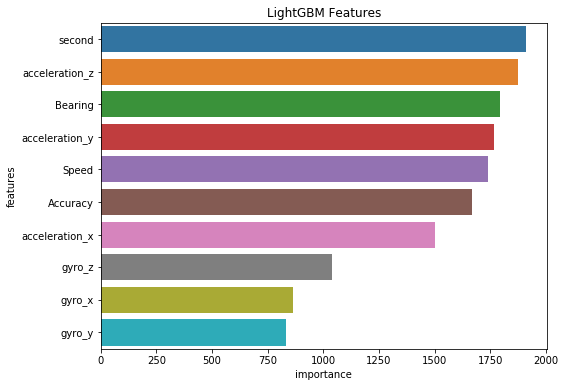

In [24]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="features", 
            data=features_df.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features')
plt.show()